In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/contractions/english_contractions.json


> ## Lectura de data sets

In [2]:
df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

## EDA

In [3]:
import matplotlib.pyplot as plt

In [4]:
# extracting the number of examples of each class
real_tweets = df_train[df_train['target'] == 1]
not_real_tweets = df_train[df_train['target'] == 0]

In [5]:
real_len = real_tweets.shape[0]
not_real_len = not_real_tweets.shape[0]
print("Cantidad de tweets reales:", real_len)
print("Cantidad de tweets falsos:",not_real_len)

Cantidad de tweets reales: 3271
Cantidad de tweets falsos: 4342


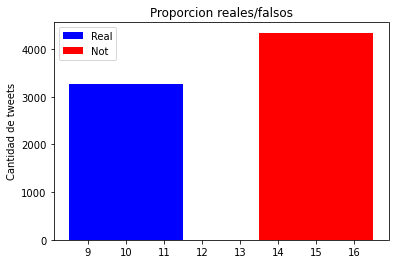

In [6]:
# bar plot of the 2 classes
plt.bar(10,real_len,3, label="Real", color='blue')
plt.bar(15,not_real_len,3, label="Not", color='red')
plt.legend()
plt.ylabel('Cantidad de tweets')
plt.title('Proporcion reales/falsos')
plt.show()

## Text preprocess

https://kavita-ganesan.com/text-preprocessing-tutorial/#.XybT-h-YU8q

In [7]:
!pip install symspellpy

     |████████████████████████████████| 2.6 MB 409 kB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [8]:
#Importamos librerias de pre procesamiento de texto
import nltk
import re
import string
from nltk.corpus import stopwords

from tqdm import tqdm
import spacy
from symspellpy.symspellpy import SymSpell, Verbosity
import pkg_resources
import json

In [9]:
print("Train Shape:", df_train.shape)
print("Test Shape:", df_test.shape)

Train Shape: (7613, 5)
Test Shape: (3263, 4)


### Punctuation Removal

In [10]:
#utilizamos la libreria "re" para limpieza de texto
#uso funcion 
#re.sub(pattern, repl, string, count=0, flags=0)
#elimino corchetes, links, <>, puntuaciones, saltos de linea
#y remuevo las palabras que contienen numeros

#remuevo todas las puntuaciones salvo # y @
#no remuevo urls pq los pienso reemplazar mas adelante
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    #text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    punctuations_to_remove = string.punctuation.replace("#","")
    punctuations_to_remove = punctuations_to_remove.replace("@","")
    text = re.sub('[%s]' % re.escape(punctuations_to_remove), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

#Remuevo emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


In [11]:
sample = "!#$%&hola'()*+, -./:;<=>?@[\]^_`{|}~"
print(clean_text(sample))

#hola @


### Text Normalization - Stemming/Lemmatization

In [12]:
#Penn Treebank Tokenizer
#The Treebank tokenizer uses regular expressions to tokenize text as in Penn Treebank.

def myStemmer(text):
    tokenizer = nltk.tokenize.TreebankWordTokenizer()
    tokens = tokenizer.tokenize(text)
    stemmer = nltk.stem.PorterStemmer()
    stemmed_list = []
    for token in tokens:
        stemmed_list.append(stemmer.stem(token))
    stemmed_text = ""
    separator = ' '
    stemmed_text = separator.join(stemmed_list)
    return stemmed_text

def myLemmatizer(text):
    tokenizer = nltk.tokenize.TreebankWordTokenizer()
    tokens = tokenizer.tokenize(text)
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemmatized_list = []
    for token in tokens:
        lemmatized_list.append(lemmatizer.lemmatize(token))
    lemmatized_text = ""
    separator = ' '
    lemmatized_text = separator.join(lemmatized_list)
    return lemmatized_text
    

In [13]:

#The strip() method returns a 
#copy of the string by removing both the leading and the 
#trailing characters (based on the string argument passed).

def lemmatize(sentence):
    nlp = spacy.load('en')
    return (_lemmatize_text(sentence, nlp).strip())
    
def _lemmatize_text(sentence, nlp):
    sent = ""
    doc = nlp(sentence)
    for token in doc:
        if '@' in token.text:
            sent+=" @MENTION"
        elif '#' in token.text:
            sent+= " #HASHTAG"
        else:
            sent+=" "+token.lemma_
    return sent

### Simplify Punctuation and whitespace

In [14]:
def simplify(sentence):
    sent = _replace_urls(sentence)
    sent = _simplify_punctuation(sent)
    sent = _normalize_whitespace(sent)
    return sent

def _replace_urls(text):
    url_regex = r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'
    text = re.sub(url_regex, "<URL>", text)
    return text

def _simplify_punctuation(text):
    """
    This function simplifies doubled or more complex punctuation. The exception is '...'.
    """
    corrected = str(text)
    corrected = re.sub(r'([!?,;])\1+', r'\1', corrected)
    corrected = re.sub(r'\.{2,}', r'...', corrected)
    return corrected

def _normalize_whitespace(text):
    """
    This function normalizes whitespaces, removing duplicates.
    """
    corrected = str(text)
    corrected = re.sub(r"//t",r"\t", corrected)
    corrected = re.sub(r"( )\1+",r"\1", corrected)
    corrected = re.sub(r"(\n)\1+",r"\1", corrected)
    corrected = re.sub(r"(\r)\1+",r"\1", corrected)
    corrected = re.sub(r"(\t)\1+",r"\1", corrected)
    return corrected.strip(" ")

### Substitution of contractions:

In [15]:
def normalize_contractions(text, contractions):
    """
    This function normalizes english contractions.
    """
    new_token_list = []
    token_list = text.split()
    for word_pos in range(len(token_list)):
        word = token_list[word_pos]
        first_upper = False
        if word[0].isupper():
            first_upper = True
        if word.lower() in contractions:
            replacement = contractions[word.lower()]
            if first_upper:
                replacement = replacement[0].upper()+replacement[1:]
            replacement_tokens = replacement.split()
            if len(replacement_tokens)>1:
                new_token_list.append(replacement_tokens[0])
                new_token_list.append(replacement_tokens[1])
            else:
                new_token_list.append(replacement_tokens[0])
        else:
            new_token_list.append(word)
    sentence = " ".join(new_token_list).strip(" ")
    return sentence

In [16]:
contraction_list = json.loads(open('../input/contractions/english_contractions.json', 'r').read())    
sample = "I'm afraid btw..."
print(normalize_contractions(sample, contraction_list))

I am afraid btw...


### Spell Correction:
Esta correcion ortografica genera algunos cambios inseperados dado que no se tiene en cuenta el contexto, esto es comun en los "spell correcting dictionaries" como el modulo symspellpy. También se podria entrenar un modelo "deep learning" para correcion ortografica basado en el contexto.

In [17]:
def init_spellchecker():
    max_edit_distance_dictionary= 3
    prefix_length = 4
    spellchecker = SymSpell(max_edit_distance_dictionary, prefix_length)
    dictionary_path = pkg_resources.resource_filename(
        "symspellpy", "frequency_dictionary_en_82_765.txt")
    bigram_path = pkg_resources.resource_filename(
        "symspellpy", "frequency_bigramdictionary_en_243_342.txt")
    spellchecker.load_dictionary(dictionary_path, term_index=0, count_index=1)
    spellchecker.load_bigram_dictionary(dictionary_path, term_index=0, count_index=2)
    return spellchecker
    
def spell_correction(text, spellchecker):
    """
    This function does very simple spell correction normalization using pyspellchecker module. It works over a tokenized sentence and only the token representations are changed.
    """
    if len(text) < 1:
        return ""
    #Spell checker config
    max_edit_distance_lookup = 2
    suggestion_verbosity = Verbosity.TOP # TOP, CLOSEST, ALL
    #End of Spell checker config
    token_list = text.split()
    for word_pos in range(len(token_list)):
        word = token_list[word_pos]
        if word is None:
            token_list[word_pos] = ""
            continue
        if not '\n' in word and word not in string.punctuation and not is_numeric(word) and not (word.lower() in spellchecker.words.keys()):
            suggestions = spellchecker.lookup(word.lower(), suggestion_verbosity, max_edit_distance_lookup)
            #Checks first uppercase to conserve the case.
            upperfirst = word[0].isupper()
            #Checks for correction suggestions.
            if len(suggestions) > 0:
                correction = suggestions[0].term
                replacement = correction
            #We call our _reduce_exaggerations function if no suggestion is found. Maybe there are repeated chars.
            else:
                replacement = _reduce_exaggerations(word)
            #Takes the case back to the word.
            if upperfirst:
                replacement = replacement[0].upper()+replacement[1:]
            word = replacement
            token_list[word_pos] = word
    return " ".join(token_list).strip()

def _reduce_exaggerations(text):
    """
    Auxiliary function to help with exxagerated words.
    Examples:
        woooooords -> words
        yaaaaaaaaaaaaaaay -> yay
    """
    correction = str(text)
    #TODO work on complexity reduction.
    return re.sub(r'([\w])\1+', r'\1', correction)

def is_numeric(text):
    for char in text:
        if not (char in "0123456789" or char in ",%.$"):
            return False
    return True


### Tokenization & Stop-words removal

In [18]:
def tokenize(words_list):
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    return tokenizer.tokenize(words_list)

def remove_stopwords(text, stop_words_list = stopwords.words('english')):
    words = []
    for w in text:
        if w not in stop_words_list:
            words.append(w)
    return words

def combine_text(list_of_text):
    combined_text = ' '.join(list_of_text)
    return combined_text

In [19]:
def text_preprocessing(text, nlp, contractions, spellchecker):
    text = simplify(text)
    text = normalize_contractions(text, contractions)
    text = spell_correction(text, spellchecker)
    #la limpieza la hago al final dado 
    #que remueve todas las puntuaciones y muchas son importantes
    #para la normalizacion del texto como (')
    text = clean_text(text)
    #text = myLemmatizer(text)
    #text = myStemmer(text)
    text = _lemmatize_text(text, nlp).strip()
    return text

### Aplico funciones de preprocesamiento al data set

In [20]:
#pre- procesamiento
df_train.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [21]:
df_train['text'][5]

'#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires'

In [22]:
nlp = spacy.load('en')
spellchecker = init_spellchecker()
contraction_list = json.loads(open('../input/contractions/english_contractions.json', 'r').read())    
#Train set
df_train['text'] = df_train['text']\
    .apply(lambda x: text_preprocessing(x, nlp, contraction_list, spellchecker))
#Test set
df_test['text'] = df_test['text']\
    .apply(lambda x: text_preprocessing(x, nlp, contraction_list, spellchecker))

In [23]:
df_train['text'][5]

'#HASHTAG rockyfire update   california hwy   close in both direction due to lake county fire   afire wildfire'

In [24]:
df_train.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,-PRON- deed be the reason of this earthquake m...,1
1,4,NaN,NaN,forest fire near la range sask canada,1
2,5,NaN,NaN,all resident ask to shelter in place be be not...,1
3,6,NaN,NaN,people receive wildfire evacuation order in ca...,1
4,7,NaN,NaN,just get send this photo from ruby alaska as s...,1
5,8,NaN,NaN,#HASHTAG rockyfire update california hwy c...,1
6,10,NaN,NaN,flood disaster heavy rain cause flash flooding...,1
7,13,NaN,NaN,i be on top of the hill and i can see a fire i...,1
8,14,NaN,NaN,there have an emergency evacuation happen now ...,1
9,15,NaN,NaN,i be afraid that the tornado be come to -PRON-...,1


In [25]:
df_test.head(10)

,id,keyword,location,text
0,0,NaN,NaN,just happen a terrible car crash
1,2,NaN,NaN,hear about earthquake be different city stay s...
2,3,NaN,NaN,there be a forest fire at spot pond geese be f...
3,9,NaN,NaN,apocalypse light spokane wildfire
4,11,NaN,NaN,typhoon soudelor kill in china and taiwan
5,12,NaN,NaN,-PRON- be shakingit an earthquake
6,21,NaN,NaN,-PRON- have probably still show more life than...
7,22,NaN,NaN,hey how be -PRON-
8,27,NaN,NaN,what a nice hat
9,29,NaN,NaN,fuck off


## Models

**Text classification**
https://monkeylearn.com/text-classification/#:~:text=Text%20classification%20is%20the%20process,spam%20detection%2C%20and%20intent%20detection.

**Stacking Scikit-Learn API**
https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/

Defino los modelos a utilizar para entrenar

The get_stacking() function below defines the StackingClassifier model by first defining a list of tuples for the five base models, then defining the logistic regression meta-model to combine the predictions from the base models using 5-fold cross-validation.

https://towardsdatascience.com/handling-imbalanced-datasets-in-deep-learning-f48407a0e758

Hipotesis sobre pesos de las clases:
Del tp1 sabemos que es mas facil identificar tweets hechos no reales porque estos tienden a ser cortos, estar mal escritos y carecen de palabras claves mientras que los tweets que son sobre desastres pueden suelen estar mejor escritos y utilizan terminos relacionados a accidentes y palabras claves.
Por lo tanto buscamos que los tweets que son sobre accidentes tengan un peso menor para asi dar mas enfasis a los casos dificiles de clasificar.

Lista de HP que no funcionaron:
- lr: C > 0.1 or C < 0.1 
- lr: class_weight predefinido

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC, OneClassSVM
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier, Perceptron, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer, Normalizer
from sklearn.pipeline import make_pipeline

from matplotlib import pyplot

#Al final el paramtro 'balanced' termino dando mejores resultados que predefinir el peso de las clases
class_weight={1:0.5, 
              0:0.5}

def get_models():
    models = dict()
    #linear_model
    models['lr'] = LogisticRegression(max_iter=1000, class_weight='balanced', C=1e-1)
    models['rc'] = RidgeClassifier()
    models['sdgc'] = SGDClassifier()
    models['knn'] = KNeighborsClassifier()
    models['cart'] = DecisionTreeClassifier()
    #models['svm'] = SVC()
    models['lSvc'] = LinearSVC(max_iter = 1500)
    models['nuSvc'] = NuSVC()
    #models['OCSvm'] = OneClassSVM()
    #models['gnb'] = GaussianNB()
    models['mnb'] = MultinomialNB()
    models['cnb'] = ComplementNB()
    models['per'] = Perceptron()
    return models

def get_stacking(models):
    #define the base models
    level_0 = list()
    for name, model in models.items():
        level_0.append((name,model))
    level_1 = LogisticRegression(max_iter=1000)
    model = StackingClassifier(estimators=level_0, 
                               final_estimator=level_1)
    return model

def evaluate_model(model, train_vectors):
    #cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = model_selection.cross_val_score(model, train_vectors, df_train['target'], cv=5, scoring = 'f1')
    return scores 

## Preparo y evaluo los distintos modelos

### Feature Extraction
Utilizo BOW y TF-IDF para extraera las features a partir del texto

In [27]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

In [28]:
#Feature extraction - BOW
count_vectorizer = CountVectorizer()
train_bow = count_vectorizer.fit_transform(df_train['text'])
#print(count_vectorizer.get_feature_names())
test_bow = count_vectorizer.transform(df_test['text'])

In [29]:
#TF IDF
tfidf_vectorizer = TfidfVectorizer()
train_tfidf = tfidf_vectorizer.fit_transform(df_train['text'])
#print(tfidf_vectorizer.get_feature_names())
test_tfidf = tfidf_vectorizer.transform(df_test['text'])

### Evaluate models

In [30]:
models = get_models()
results, names = list(), list()
print("BOW")
for name, model in models.items():
    scores = evaluate_model(model, train_bow)
    results.append(scores)
    names.append(name)
    print(name, scores)

BOW
lr [0.64965986 0.59412232 0.64773599 0.60402685 0.74907476]
rc [0.59074733 0.49380677 0.54054054 0.53699086 0.64328358]
sdgc [0.60370697 0.50328947 0.56025039 0.5505341  0.6572909 ]
knn [0.23529412 0.23076923 0.22365039 0.22278481 0.23949045]
cart [0.59982254 0.48821549 0.53858025 0.53018373 0.61483595]
lSvc [0.60674157 0.51077414 0.58918129 0.55343828 0.64482502]
nuSvc [0.62122687 0.55575868 0.6270903  0.57824427 0.72935405]
mnb [0.65256306 0.61640798 0.6744186  0.65602554 0.74804826]
cnb [0.65822785 0.61461318 0.67515924 0.65838509 0.74618585]
per [0.58647937 0.49880858 0.54571843 0.58322057 0.63838384]


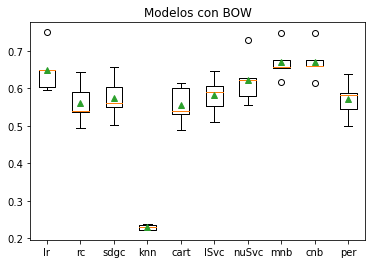

In [31]:
plt.boxplot(results, labels=names, showmeans=True)
plt.title('Modelos con BOW')
plt.show()

In [32]:
models = get_models()
results_tfidf, names_tfidf = list(), list()
print("TF IDF")
for name, model in models.items():
    scores = evaluate_model(model, train_tfidf)
    results_tfidf.append(scores)
    names_tfidf.append(name)
    #print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
    print(name, scores)

TF IDF
lr [0.64317181 0.61836442 0.67193108 0.64167916 0.72163495]
rc [0.59945504 0.54808511 0.5962632  0.58823529 0.6976378 ]
sdgc [0.60940325 0.55817738 0.59029435 0.58645276 0.70183486]
knn [0.52156469 0.51084813 0.55447471 0.47821878 0.60724234]
cart [0.52859619 0.47550201 0.52       0.50626566 0.58118361]
lSvc [0.61375661 0.55273917 0.60829493 0.58442695 0.68396947]
nuSvc [0.60997067 0.5606469  0.59845228 0.57976654 0.72997523]
mnb [0.57418112 0.60705073 0.64033613 0.57899716 0.73306122]
cnb [0.63643997 0.62835821 0.66178624 0.62718932 0.75289017]
per [0.57189542 0.48835341 0.58722182 0.55129209 0.6021978 ]


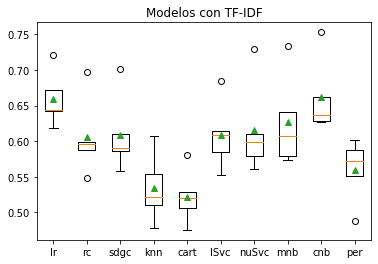

In [33]:
plt.boxplot(results_tfidf, labels=names_tfidf, showmeans=True)
plt.title('Modelos con TF-IDF')
plt.show()

## Evaluo Stacking y comparo con los modelos

A partir de los scores de cada modelo podemos ver que la vectorizacion con BOW tiene valores 
con menor varianza mientras que TF-IDF tiende a haber una distancia mayor entre minimos y maximos de scores
Los 4 mejores modelos en ambos casos son LogisticRegression, MultioniamlNB, ComplementeNB y NuSVC()

Vuelvo a definir el modelo de stacking pero con solo estas 4

In [34]:
def get_best_stacking():
    level_0 = list()
    level_0.append(("lr", LogisticRegression(max_iter = 150, class_weight='balanced', C=1e-1)))
    level_0.append(("cnb", ComplementNB(alpha=1)))
    level_0.append(("mnb", MultinomialNB(alpha=1)))
    level_0.append(("nuSvc", NuSVC()))
    level_1= LogisticRegression()
    model = StackingClassifier(estimators=level_0, final_estimator=level_1)
    return model

In [35]:
best_stacking = get_best_stacking()
#Stacking 3 modelos + BOW
scores = evaluate_model(best_stacking, train_bow) 
print(scores)
#Stacking 3 modelos + TF-IDF
scores_tfidf = evaluate_model(best_stacking, train_tfidf)
print(scores_tfidf)

[0.6481149  0.6192733  0.66403785 0.62543554 0.77286585]
[0.63185841 0.61649319 0.66878981 0.60980036 0.75589354]


In [36]:
results.append(scores)
names.append("stacking")

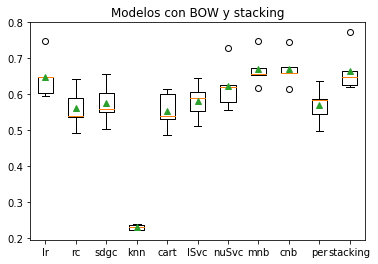

In [37]:
plt.boxplot(results, labels=names, showmeans=True)
plt.title('Modelos con BOW y stacking')
plt.show()

In [38]:
results_tfidf.append(scores_tfidf)
names_tfidf.append("stacking")

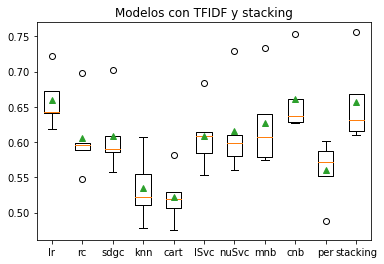

In [39]:
plt.boxplot(results_tfidf, labels=names_tfidf, showmeans=True)
plt.title('Modelos con TFIDF y stacking')
plt.show()

### Hiper-parametros feature extraction
Probamos cambiar los hiperparametros de los algoritmos de feature extraction

Lista de hiperparametros que no funcionaron:
- strip_accents
- stop_words
- ngram_range
- max_df
- min_df



### Feature preprocess - Pipeline

In [40]:
from xgboost import XGBClassifier

In [41]:
pipeline_models, pipeline_names= list(), list()

models_pip = dict()
models_pip['svc'] = SVC()
#models_pip['ocs'] = OneClassSVM()
#models_pip['gnb'] = GaussianNB()


Agrego al diccionario los mismos modelos pero como un pipeline
con transformaciones de los features

In [42]:
models_pip['svc_p'] = make_pipeline(StandardScaler(with_mean=False),SVC())
#models_pip['gnb_p'] = make_pipeline(StandardScaler(with_mean=False), GaussianNB())
#models_pip['ocs_p'] = make_pipeline(StandardScaler(with_mean=False), OneClassSVM())


In [43]:
#sacado de Fork of TP2,
clf = XGBClassifier(objective = 'binary:logistic', 
                    random_state=42, 
                    seed=2, 
                    colsample_bytree=0.5, 
                    subsample=0.7,
                    learning_rate=0.1,
                    n_estimators=300
                    )

In [44]:
print(evaluate_model(clf, train_bow))

[0.5988806  0.46601942 0.54760031 0.52521408 0.66559743]


In [45]:
clf.fit(train_bow,df_train['target'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=2,
              subsample=0.7, tree_method='exact', validate_parameters=1,
              verbosity=None)

## Model Fitting
Utilizo el mejor modelo que es el Stack con los algoritmos de sklearn

In [46]:
best_stacking.fit(train_bow, df_train['target'])

StackingClassifier(estimators=[('lr',
                                LogisticRegression(C=0.1,
                                                   class_weight='balanced',
                                                   max_iter=150)),
                               ('cnb', ComplementNB(alpha=1)),
                               ('mnb', MultinomialNB(alpha=1)),
                               ('nuSvc', NuSVC())],
                   final_estimator=LogisticRegression())

In [47]:
def submission(submission_file_path, model ,test_vectors):
    sample_submission = pd.read_csv(submission_file_path)
    sample_submission['target'] = model.predict(test_vectors)
    sample_submission.to_csv("submission.csv", index=False)

In [48]:
submission_file_path = "../input/nlp-getting-started/sample_submission.csv"
submission_test_vectors=test_bow
#Eligo el metodo que me dio mayor puntaje, en este caso fue el Naive Bayes con TF_IDF
submission(submission_file_path,best_stacking, submission_test_vectors)


## Verifico submission

In [49]:
df_sub = pd.read_csv("./submission.csv")
df_test_copy = df_test.copy(deep=True)
df_test_copy.head()

,id,keyword,location,text
0,0,NaN,NaN,just happen a terrible car crash
1,2,NaN,NaN,hear about earthquake be different city stay s...
2,3,NaN,NaN,there be a forest fire at spot pond geese be f...
3,9,NaN,NaN,apocalypse light spokane wildfire
4,11,NaN,NaN,typhoon soudelor kill in china and taiwan


In [50]:
df_test_copy['target'] = df_sub['target']
df_test_copy.head(20)

,id,keyword,location,text,target
0,0,NaN,NaN,just happen a terrible car crash,1
1,2,NaN,NaN,hear about earthquake be different city stay s...,0
2,3,NaN,NaN,there be a forest fire at spot pond geese be f...,1
3,9,NaN,NaN,apocalypse light spokane wildfire,1
4,11,NaN,NaN,typhoon soudelor kill in china and taiwan,1
5,12,NaN,NaN,-PRON- be shakingit an earthquake,1
6,21,NaN,NaN,-PRON- have probably still show more life than...,0
7,22,NaN,NaN,hey how be -PRON-,0
8,27,NaN,NaN,what a nice hat,0
9,29,NaN,NaN,fuck off,0
